In [1]:
import os
import numpy as np
from os import makedirs

BBO_experiments_dict = {
  
    "BBO MBTR/RBF 10 rdkit": os.environ["DATA"] + "/07_BBO/03_bbo_optim/paper/03.01_optim_HOMO_mbtr_rbf_10_steps",
}

EvoMol_experiments_dict = {
    "EvoMol rdkit": os.environ["DATA"] + "/07_BBO/03_bbo_optim/paper/01.01_EvoMol_from_methane_optim_HOMO_rdkit_nocache",
}

output_figures_root = os.environ["FIGURES"] + "/07_BBO/03_bbo_optim/poster/10.01_results"
makedirs(output_figures_root, exist_ok=True)

sub_experiments_names = [str(i) for i in range(1, 11)]

ECDF_TARGETS = np.arange(-10, -3, 0.01)
ERT_TARGETS = np.arange(-10, -1, 0.5)

In [43]:
groups = [
          
    (
        "",
        ["BBO MBTR/RBF 10 rdkit", "EvoMol rdkit"],
        {
            "EvoMol rdkit": "EA optimization of the DFT-evaluated HOMO (no surrogate)",
            "BBO MBTR/RBF 10 rdkit": "EA optimization of the surrogate (proposed approach)",
        },
        [0, 1],
        [None, None]
    ),

    
]


In [22]:
from bbomol.postprocessing import extract_multiple_BBO_experiments_data, extract_multiple_evomol_experiments_data

def extract_all_data(BBO_experiments_dict, EvoMol_experiments_dict, sub_experiments_names):
    
    results_dict = {}
    
    for exp_name, path in BBO_experiments_dict.items():
        results_dict[exp_name] = extract_multiple_BBO_experiments_data(path, sub_experiments_names)
        
    for exp_name, path in EvoMol_experiments_dict.items():
        results_dict[exp_name] = extract_multiple_evomol_experiments_data(path, sub_experiments_names)

    return results_dict

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from bbomol.evaluation import compute_ecdf, compute_best_so_far_matrix

from os.path import join
import pandas as pd
from matplotlib.ticker import FuncFormatter
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (1, 10))]
markers = ['s', '^', 'o', '+', 'x']
from math import floor


def plot_best_so_far(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None, 
                     classes_dashes=None, classes_markers=None, metric="mean"):
    
    plt.figure(figsize=(7, 2))
    
    if plot_title is not None:        
        plt.title(plot_title)
    
    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
        
    for i, experiment_name in enumerate(exp_list_plot):
        
        if experiment_name in exp_list_plot:
            
            if labels_dict is not None and experiment_name in labels_dict:
                display_experiment_name = labels_dict[experiment_name]
            else:
                display_experiment_name = experiment_name
                
               
            max_obj_calls = np.max([np.max(obj_calls_vect) for obj_calls_vect in results_dict[experiment_name]["dataset_success_n_calls"]])
                
            obj_calls, best_so_far_matrix = compute_best_so_far_matrix(
                results_dict[experiment_name]["dataset_success_n_calls"],
                results_dict[experiment_name]["dataset_success_obj_value"],
                max_obj_calls=max_obj_calls
            )
            
            
            if classes_dashes is None:
                linestyle = linestyles[0]
            else:
                linestyle = linestyles[classes_dashes[i]]
                
            if classes_markers is None:
                marker = None
            else:
                marker = markers[classes_markers[i]] if classes_markers[i] is not None else None
            
            if metric == "mean" or metric == "both":
                plt.plot(obj_calls, best_so_far_matrix.mean(axis=0), label=display_experiment_name, 
                         linestyle=linestyle, markevery=100)
                plt.ylabel("Best HOMO (eV)")
            if metric == "min_max" or metric == "both":
                plt.fill_between(obj_calls, best_so_far_matrix.min(axis=0), best_so_far_matrix.max(axis=0),
                                 alpha=0.2)
#                                  label=display_experiment_name, )

                
        
#     plt.legend(loc="lower right")
    plt.xlim(1, 1000)
    plt.ylim(-7, -2)
    plt.xlabel("Number of DFT calls")
    plt.savefig(join(output_figures_root, "best_so_far_" + metric + "_" + plot_title +".png"), 
                dpi=400, bbox_inches='tight', transparent=True)
    plt.show()


In [46]:
results_dict = extract_all_data(BBO_experiments_dict, EvoMol_experiments_dict, sub_experiments_names)

# Best so far  (mean)

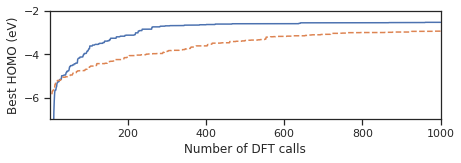

In [47]:
for group in groups:
    plot_best_so_far(results_dict, group[0], group[1], labels_dict=group[2], classes_dashes=group[3],
                     classes_markers=group[4], metric="mean")

# Best so far (min_max)

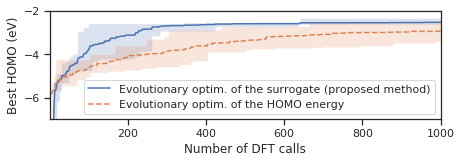

In [7]:
for group in groups:
    plot_best_so_far(results_dict, group[0], group[1], labels_dict=group[2], classes_dashes=group[3],
                     classes_markers=group[4], metric="both")